# Gulf Stream Index

The notebook is to recreate the Gulf Stream Index calculation in detail. Original sources are [Ross et al., 2023](https://gmd.copernicus.org/articles/16/6943/2023/).
and [GFDL CEFI github repository](https://github.com/NOAA-GFDL/CEFI-regional-MOM6/blob/main/diagnostics/physics/ssh_eval.py).

This notebook also utilize the [regional_mom6 package](https://github.com/NOAA-PSL/regional_mom6) 

The index calculation will be included into the package for future use.

In [2]:
import xarray as xr
from mom6.mom6_module import mom6_process as mp

## Input the MOM6 raw grid 

In [3]:
ds = mp.MOM6Historical.get_mom6_all('ssh',grid='raw')

In [4]:
ds

<xarray.Dataset> Size: 914MB
Dimensions:       (xh: 775, yh: 845, time: 324, xq: 776, yq: 846, nv: 2)
Coordinates: (12/14)
  * xh            (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh            (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * time          (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-1...
  * xq            (xq) float64 6kB -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yq            (yq) float64 7kB 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
    geolon        (yh, xh) float32 3MB ...
    ...            ...
    geolat_c      (yq, xq) float32 3MB ...
    geolon_u      (yh, xq) float32 3MB ...
    geolat_u      (yh, xq) float32 3MB ...
    geolon_v      (yq, xh) float32 3MB ...
    geolat_v      (yq, xh) float32 3MB ...
  * nv            (nv) float64 16B 1.0 2.0
Data variables: (12/22)
    areacello     (yh, xh) float32 3MB ...
    deptho        (yh, xh) float32 3MB ...
    sftof         (yh, xh) float32 3MB ...
    Coriolis      (yq, xq) float32 3MB ...
    wet           (yh, xh) float32 3MB ...
    wet_c         (yq, xq) float32 3MB ...
    ...            ...
    areacello_bu  (yq, xq) float32 3MB ...
    average_DT    (time) timedelta64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    ssh           (time, yh, xh) float32 849MB dask.array<chunksize=(22, 225, 206), meta=np.ndarray>
    time_bnds     (time, nv) datetime64[ns] 5kB dask.array<chunksize=(324, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          NWA12_MOM6_v1.0
    grid_type:      regular
    grid_tile:      N/A

In [5]:
# change longitude range from -180 180 to 0 360
ds['geolon'] = ds['geolon']+360.

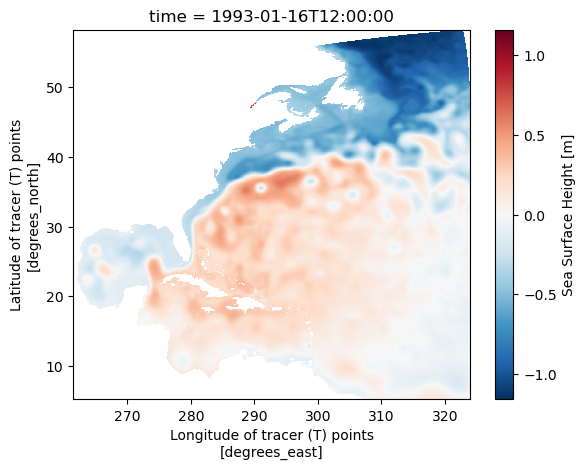

In [6]:
ds.ssh.isel(time=0).plot(x='geolon',y='geolat')

## Define the focus region for Gulf Stream location
based on the original script, this is hard coded between 72W-51.9W and 36N-42N rectangle. We can plot the rectangle region on top of a monthly sea surface height map to show the region of interest.

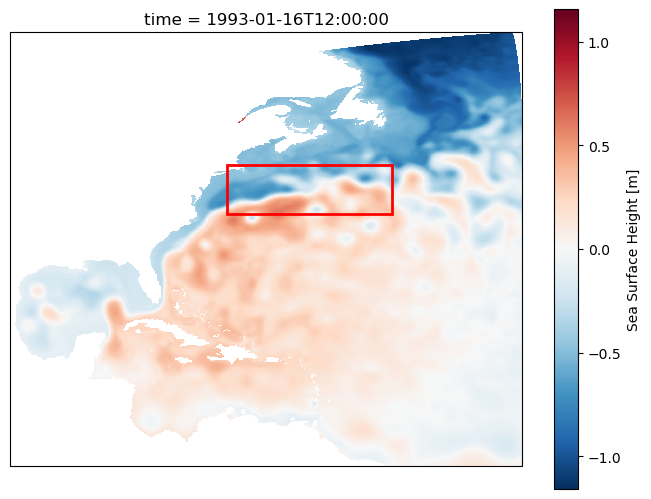

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Rectangle

# Define the longitude and latitude range of the rectangle
lon_min, lon_max = -72, -51.9
lat_min, lat_max = 36, 42

# Create a new matplotlib figure and axes with cartopy projection
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1], projection=ccrs.PlateCarree())
ds.ssh.isel(time=0).plot(x='geolon',y='geolat',ax=ax1)

# Add a rectangle patch
rectangle = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                      edgecolor='red', facecolor='none', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rectangle)

## Regridding the original raw grid data 
In the region of interest, the data are regridded from the original raw grid (~0.1 x 0.1) to a fix resolution of 1(longitude) x 0.1(latitude). 

In [13]:
import numpy as np
x = np.arange(360-72, 360-51.9, 1)
y = np.arange(36, 42, 0.1)

In [14]:
x

array([288., 289., 290., 291., 292., 293., 294., 295., 296., 297., 298.,
       299., 300., 301., 302., 303., 304., 305., 306., 307., 308.])

In [15]:
y

array([36. , 36.1, 36.2, 36.3, 36.4, 36.5, 36.6, 36.7, 36.8, 36.9, 37. ,
       37.1, 37.2, 37.3, 37.4, 37.5, 37.6, 37.7, 37.8, 37.9, 38. , 38.1,
       38.2, 38.3, 38.4, 38.5, 38.6, 38.7, 38.8, 38.9, 39. , 39.1, 39.2,
       39.3, 39.4, 39.5, 39.6, 39.7, 39.8, 39.9, 40. , 40.1, 40.2, 40.3,
       40.4, 40.5, 40.6, 40.7, 40.8, 40.9, 41. , 41.1, 41.2, 41.3, 41.4,
       41.5, 41.6, 41.7, 41.8, 41.9])

In [16]:
# Create an xarray dataset with empty dataarray and designed grid
data = xr.DataArray(
    data=None,
    coords={'lon': x, 'lat': y},
    dims=('lon', 'lat')
)
ds_regrid = xr.Dataset({'var': data})


In [17]:
ds_regrid

<xarray.Dataset> Size: 11kB
Dimensions:  (lon: 21, lat: 60)
Coordinates:
  * lon      (lon) float64 168B 288.0 289.0 290.0 291.0 ... 306.0 307.0 308.0
  * lat      (lat) float64 480B 36.0 36.1 36.2 36.3 36.4 ... 41.6 41.7 41.8 41.9
Data variables:
    var      (lon, lat) object 10kB None None None None ... None None None None

In [18]:
import xesmf as xe
# use xesmf to create regridder
# !!!! regridded only suited for geolon and geolat to x and y
ds = ds.rename({'geolon':'lon','geolat':'lat'})
regridder = xe.Regridder(ds, ds_regrid, "bilinear", unmapped_to_nan=True)

In [19]:
# perform regrid for each field
ds_regrid = xr.Dataset()
ds_regrid['ssh'] = regridder(ds['ssh'])

## Compare the original grid and regrid
To quickly take a look at the original grid and the regridded result, we plot them below for a quick comparison. 

The regridded result, as expected, is a lot more rough structure than the original plot. This is due the significant decrease of longitude resolution. 

The regridding can be perform in various methods [bilinear, conservative, nearest_s2d, ...etc](https://xesmf.readthedocs.io/en/stable/notebooks/Compare_algorithms.html#Decreasing-resolution). Here we follow the original resource of using bilinear. 

The detail of using which method depend on the questions. A detail discussion of what method to use when decreasing resolution can be found [here](https://xesmf.readthedocs.io/en/stable/notebooks/Compare_algorithms.html#Decreasing-resolution). 

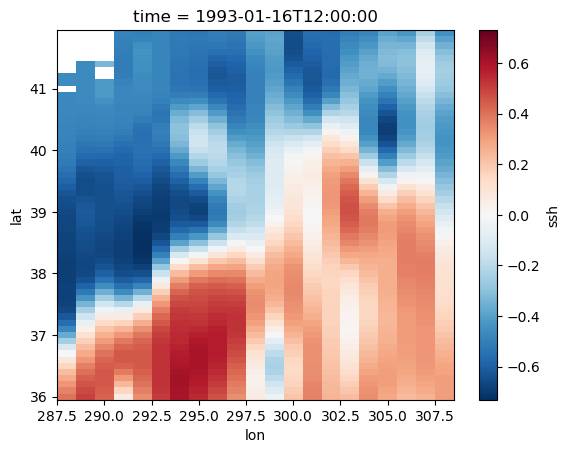

In [20]:
ds_regrid['ssh'].isel(time=0).plot()

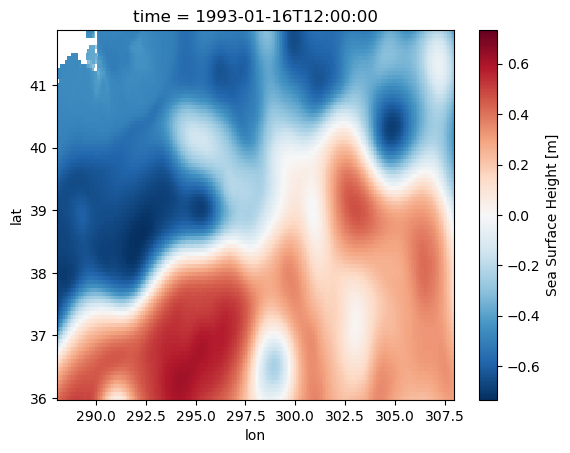

In [23]:
ds.ssh.isel(time=0).where((ds.lon>x[0])&
                          (ds.lon<x[-1])&
                          (ds.lat>y[0])&
                          (ds.lat<y[-1]),drop=True).plot(x='lon',y='lat')

## Calculate the Sea Surface Height (SSH) anomaly
We calculate the anomaly based on the monthly climatology.

In [25]:
da_regrid_anom = ds_regrid['ssh'].groupby('time.month')-ds_regrid['ssh'].groupby('time.month').mean('time')

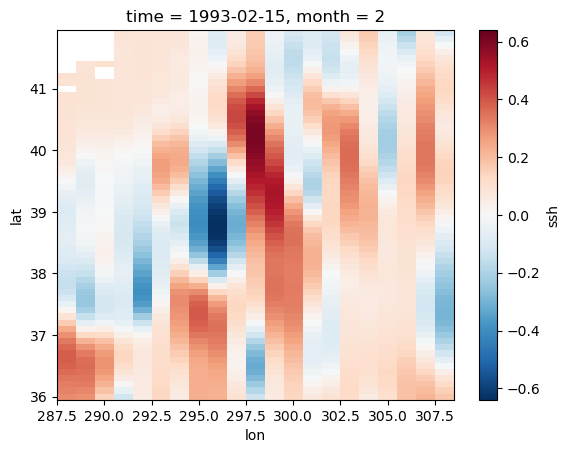

In [26]:
da_regrid_anom.isel(time=1).plot()

## Calculate the Standard Deviation of SSH Anomaly

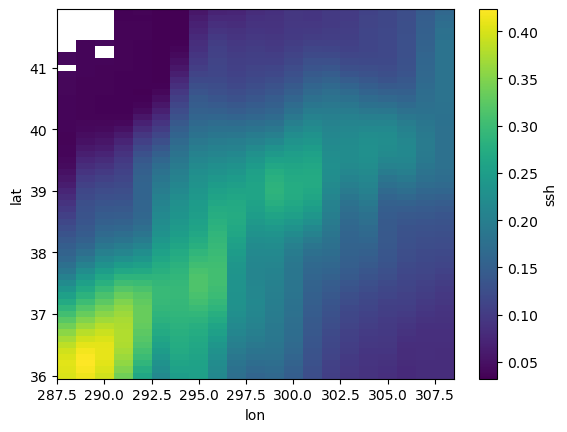

In [28]:
da_std = da_regrid_anom.std('time')
da_std.plot()

## Calculate the Latitude of Maximum Standard Deviation
- determine the maximum latitude index
- use the maximum latitude index to find the latitude

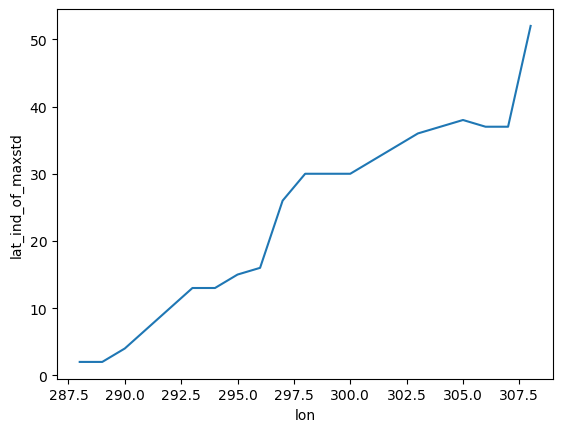

In [31]:
da_lat_ind_maxstd = da_std.argmax('lat').compute()
da_lat_ind_maxstd.name = 'lat_ind_of_maxstd'
da_lat_ind_maxstd.plot()

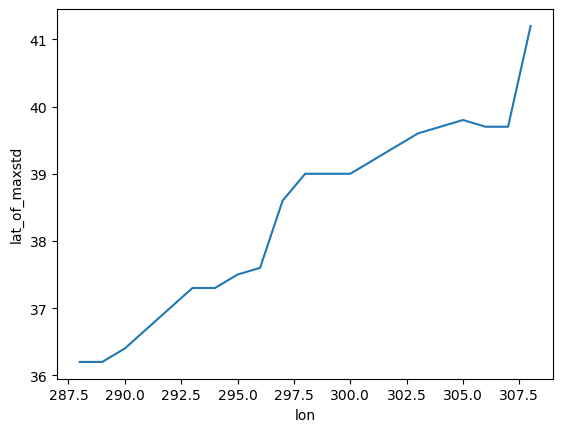

In [32]:
da_lat_maxstd = da_std.lat.isel(lat=da_lat_ind_maxstd).compute()
da_lat_maxstd.name = 'lat_of_maxstd'
da_lat_maxstd.plot()

## Calculate the Gulf Stream Index
- use the maximum latitude index to find the SSH anomaly along the line shown above.
- calculate the longitude mean of the SSH anomaly (time dependent) 
    $$\text{{SSHa}}$$
- calculate the stardarde deviation of the $\text{{SSHa}}$
    $$\text{{SSHa\_std}}$$
- calculate the index
    $$\text{{Gulf Stream Index}} = \frac{\text{{SSHa}}}{\text{{SSHa\_std}}}$$

In [33]:
da_ssh_mean_along_gs = da_regrid_anom.isel(lat=da_lat_ind_maxstd).mean('lon')
da_ssh_mean_std_along_gs = da_regrid_anom.isel(lat=da_lat_ind_maxstd).mean('lon').std('time')
da_gs_index = da_ssh_mean_along_gs/da_ssh_mean_std_along_gs

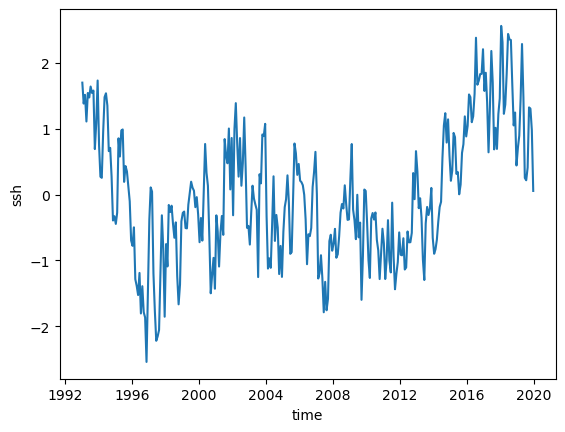

In [34]:
da_gs_index.plot()